<a href="https://colab.research.google.com/github/EngUzair98/CS867_Computer_Vision_Projects/blob/main/CS867_CV_A002_version_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries



In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, add, Input, Lambda, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Defining evaluation metric dice score
def dice_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

#Importing & Loading Dataset

In [3]:
data_dir= '/content/gdrive/MyDrive/CV_A002_Segmentation_Dataset'

In [4]:
os.listdir(data_dir)

['Test', 'Train', 'VGGUNet', 'MobileUNet']

In [25]:
class DataSet():

  def __init__(
      self,
      root_dir: str,
      mode: str
  ):
    if mode=="Train":
      self.data_dir= os.path.join(root_dir, "Train")
    elif mode=="Test":
      self.data_dir=os.path.join(root_dir, "Test")

    self.images = os.listdir(self.data_dir +"/images")
    self.annotations_mask = os.listdir(self.data_dir + "/annotations_mask") 

  def dataLoader(self):

    imgs = []
    masks = []

    for index in range(len(self.images)):
      image = tf.io.read_file(os.path.join(self.data_dir, "images", self.images[index]))
      image = tf.image.decode_png(image, channels=3)
      image = tf.image.convert_image_dtype(image, tf.float32) 

      mask = tf.io.read_file(os.path.join(self.data_dir, "annotations_mask", self.images[index]))
      mask = tf.image.decode_png(mask, channels=3)
      mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

      height, width = image.shape[0], image.shape[1]
      height -= height % 16
      width -= width % 16

      image = tf.image.resize(image, (height, width), method="nearest")
      mask = tf.image.resize(mask, (height, width), method="nearest")

      imgs.append(image)
      masks.append(mask)

    return tf.stack(imgs, axis=0), tf.stack(masks, axis=0)



In [26]:
data_train = DataSet(root_dir=data_dir, mode = "Train")
imgs_train, masks_train = data_train.dataLoader()

data_test = DataSet(root_dir = data_dir, mode = "Test")
imgs_test, masks_test = data_test.dataLoader()

In [55]:
masks_train_cat = tf.keras.utils.to_categorical(masks_train, num_classes=12)
masks_test_cat = tf.keras.utils.to_categorical(masks_test, num_classes=12)

In [56]:
masks_train_cat.shape

(367, 352, 480, 12)

In [57]:
imgs_train.shape, masks_train.shape

(TensorShape([367, 352, 480, 3]), TensorShape([367, 352, 480, 1]))

In [58]:
#Splitting Trainiing dataset further into training and validation datasets
# img_train, mask_train, img_val, mask_val = train_test_split(imgs_train, masks_train, random_state=20)

In [59]:
# img_train.shape, mask_train.shape

In [60]:
# img_val.shape, mask_val.shape

##Visulizing Training Dataset

<Figure size 432x288 with 0 Axes>

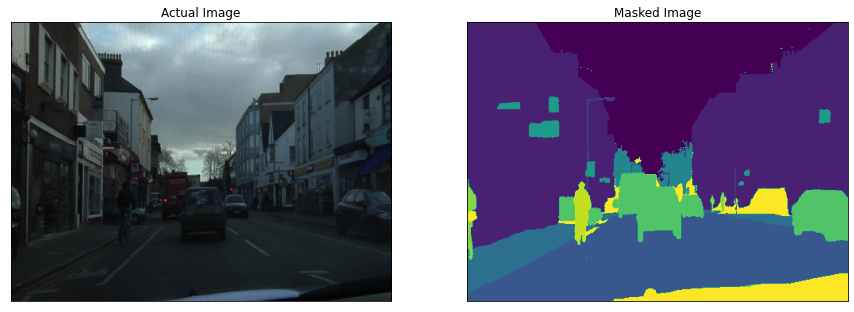

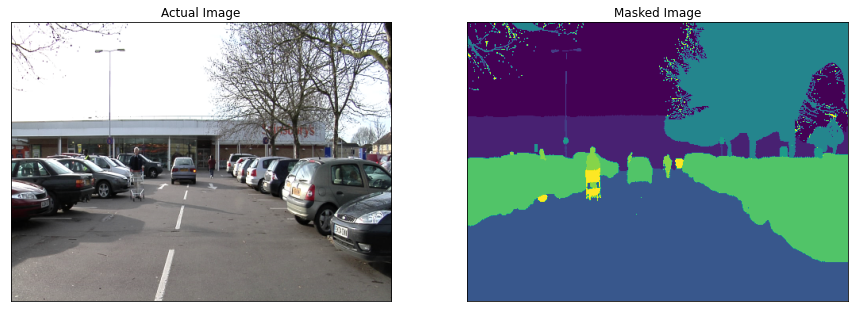

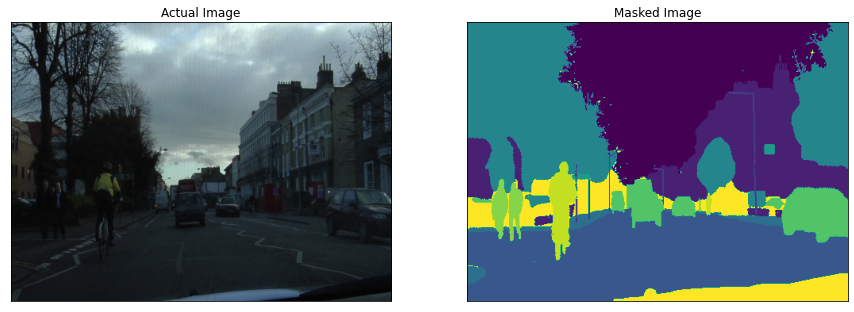

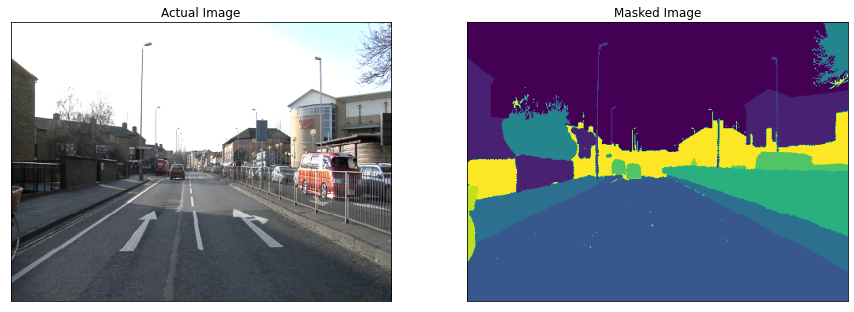

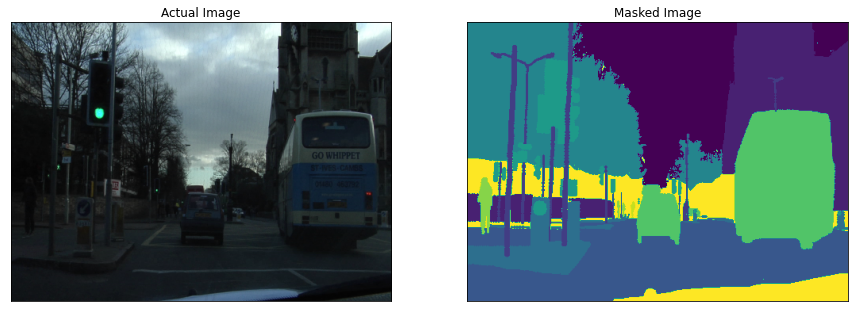

In [64]:
plt.suptitle("Training Dataset Visulization", fontsize=12)
for index in range(5):
  img= imgs_train[index]
  mask= masks_train[index]

  img_resize = (15,15)
  plt.figure(figsize= img_resize)

  plt.subplot(1,2,1)
  plt.title('Actual Image')
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1,2,2)
  plt.title('Masked Image')
  plt.imshow(tf.squeeze(mask))
  plt.xticks([])
  plt.yticks([])
  plt.show()


##Data Augmentation

In [65]:
augmented_data = ImageDataGenerator(rescale=1./255,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)

aug_trainData= augmented_data.flow(x=imgs_train, y=masks_train, batch_size= 32, shuffle= False, subset=None, save_to_dir=None, seed=None, sample_weight= None)

#UNet Implementation

In [66]:
#Defining return Conv2d layer function

def conv2d_block(input, numFilters):
  conv = Conv2D(numFilters, (3, 3), activation="leaky_relu", padding="same", kernel_initializer="he_normal")(input)
  conv = BatchNormalization()(conv)

  conv = Conv2D(numFilters, (3, 3), activation="leaky_relu", padding="same", kernel_initializer="he_normal")(conv)
  conv = BatchNormalization()(conv)

  return conv

In [67]:
#Defining Decoder block function

def decode_block(input, skip_connection, numFilter):
  upsample = Conv2DTranspose(numFilter, (2,2), strides= (2,2), padding='same')(input)
  merge = concatenate([upsample, skip_connection], axis=3)
  output = conv2d_block(merge, numFilter)

  return output


#VGG16_UNet Model

In [35]:
# vgg16 = VGG16(include_top=False, weights = 'imagenet')
# vgg16.summary()

In [72]:
def vgg16UNet(input_shape):
  input = Input(shape=input_shape)
  vgg16 = VGG16(include_top=False, weights = 'imagenet', input_tensor= input)
  e1 = vgg16.get_layer('block1_conv2').output # encoder layer 1
  e2 = vgg16.get_layer('block2_conv2').output # encoder layer 2
  e3 = vgg16.get_layer('block3_conv3').output # encoder layer 3
  e4 = vgg16.get_layer('block4_conv3').output # encoder layer 4

  b1 = vgg16.get_layer('block5_conv3').output # bridge layer

  d1 = decode_block(b1,e4,512) # decoder layer 1
  d2 = decode_block(d1,e3,256) # decoder layer 2
  d3 = decode_block(d2,e2,128) # decoder layer 3
  d4 = decode_block(d3,e1,64) # decoder layer 4

  conv2d = Conv2D(32,(3,3),padding='same', activation='relu', kernel_initializer="he_normal")(d4)

  op = Conv2D(1,1,padding='same', activation='sigmoid')(conv2d) # output layer

  modelvg = Model(input, op)

  return modelvg

In [73]:
img_size = (128,128,3)
vgg_UNet = vgg16UNet(img_size)

vgg_UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', dice_score])
vgg_UNet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [74]:
checkpoint_dir = data_dir + '/VGGUNet'

# aug_train_resize = tf.image.resize(aug_trainData, (128,128))
imgs_train_resize = tf.image.resize(imgs_train, (128,128))
masks_train_resize = tf.image.resize(masks_train, (128,128))

checkpoint_callback = ModelCheckpoint(filepath= checkpoint_dir, monitor='val_accuracy', mode='max', save_best_only=True)
vgUNet = vgg_UNet.fit(imgs_train_resize, masks_train_resize, batch_size= 32 ,epochs= 20,verbose=1,  validation_split=0.2, callbacks=[checkpoint_callback])

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3164 - dice_score: 1.3670

10/10 [==============================] - 14s 1s/step - loss: 0.0000e+00 - accuracy: 0.3164 - dice_score: 1.3670 - val_loss: 0.0000e+00 - val_accuracy: 0.1476 - val_dice_score: 0.0794
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2877 - dice_score: 1.4161

10/10 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.2877 - dice_score: 1.4161 - val_loss: 0.0000e+00 - val_accuracy: 0.2744 - val_dice_score: 1.4796
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2419 - dice_score: 1.2710

10/10 [==============================] - 13s 1s/step - loss: 0.0000e+00 - accuracy: 0.2419 - dice_score: 1.2710 - val_loss: 0.0000e+00 - val_accuracy: 0.2759 - val_dice_score: 1.4237
Epoch 4/20
10/10 [==============================] - 5s 431ms/step - loss: 0.0000e+00 - accuracy: 0.2379 - dice_score: 1.2236 - val_loss: 0.0000e+00 - val_accuracy: 0.2187 - val_dice_score: 1.3799
Epoch 5/20
10/10 [==============================] - 4s 410ms/step - loss: 0.0000e+00 - accuracy: 0.2455 - dice_score: 1.2669 - val_loss: 0.0000e+00 - val_accuracy: 0.1766 - val_dice_score: 0.9828
Epoch 6/20
10/10 [==============================] - 4s 418ms/step - loss: 0.0000e+00 - accuracy: 0.2387 - dice_score: 1.2761 - val_loss: 0.0000e+00 - val_accuracy: 0.1918 - val_dice_score: 0.8936
Epoch 7/20
10/10 [==============================] - 4s 411ms/step - loss: 0.0000e+00 - accuracy: 0.2676 - dice_score: 1.2893 - val_loss: 0.0000e+00 - val_accuracy: 0.1503 - val_dice_score: 0.4276
Epoch 8/20
10/10 [===============

10/10 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.2567 - dice_score: 1.3089 - val_loss: 0.0000e+00 - val_accuracy: 0.3504 - val_dice_score: 1.2788
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2684 - dice_score: 1.3159

10/10 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.2684 - dice_score: 1.3159 - val_loss: 0.0000e+00 - val_accuracy: 0.3571 - val_dice_score: 1.2871
Epoch 15/20
10/10 [==============================] - 4s 440ms/step - loss: 0.0000e+00 - accuracy: 0.2722 - dice_score: 1.3150 - val_loss: 0.0000e+00 - val_accuracy: 0.2100 - val_dice_score: 1.2219
Epoch 16/20
10/10 [==============================] - 4s 418ms/step - loss: 0.0000e+00 - accuracy: 0.2706 - dice_score: 1.3199 - val_loss: 0.0000e+00 - val_accuracy: 0.2501 - val_dice_score: 1.2281
Epoch 17/20
10/10 [==============================] - 4s 418ms/step - loss: 0.0000e+00 - accuracy: 0.2658 - dice_score: 1.3276 - val_loss: 0.0000e+00 - val_accuracy: 0.2533 - val_dice_score: 1.3008
Epoch 18/20
10/10 [==============================] - 4s 419ms/step - loss: 0.0000e+00 - accuracy: 0.2664 - dice_score: 1.3259 - val_loss: 0.0000e+00 - val_accuracy: 0.2495 - val_dice_score: 1.2737
Epoch 19/20
10/10 [==========

##Performance Results VGG16_UNet

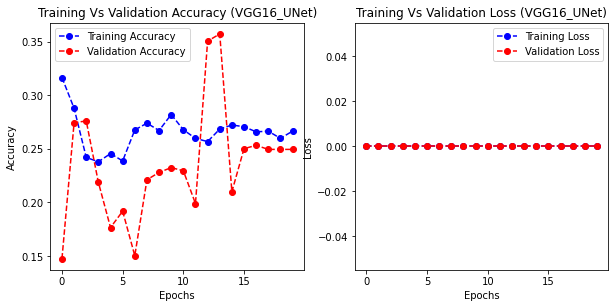

Text(0.5, 1.0, 'Training Vs Validation Dice Score (VGG16_UNet)')

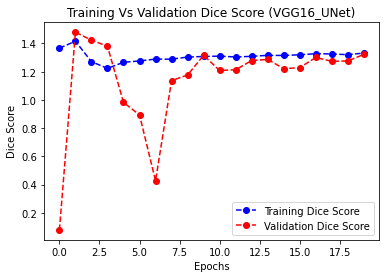

In [119]:
train_acc=vgUNet.history['accuracy']
train_loss=vgUNet.history['loss']
train_dice=vgUNet.history['dice_score']
val_dice=vgUNet.history['val_dice_score']

val_acc=vgUNet.history['val_accuracy']
val_loss=vgUNet.history['val_loss']
val_dice=vgUNet.history['val_dice_score']

plt.figure(figsize=(10,10))
#Plotting Accuracy 
plt.subplot(2,2,1)
plt.plot(train_acc,'bo--', label='Training Accuracy')
plt.plot(val_acc, 'ro--',label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training Vs Validation Accuracy (VGG16_UNet)')

#Plotting Loss
plt.subplot(2,2,2) 
plt.plot(train_loss,'bo--', label='Training Loss')
plt.plot(val_loss, 'ro--',label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training Vs Validation Loss (VGG16_UNet)')
plt.show()

#Plotting Dice Score 
plt.subplot(1,1,1)
plt.plot(train_dice,'bo--', label='Training Dice Score')
plt.plot(val_dice, 'ro--',label='Validation Dice Score')
plt.ylabel('Dice Score')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training Vs Validation Dice Score (VGG16_UNet)')

In [76]:
#Saving VGG16_UNet Model

saved_dir = data_dir + '/VGGUNet/Model'
vgg_UNet.save(saved_dir)

In [80]:
#Load Saved Model
# from tensorflow import keras
# saved_dir = data_dir + '/VGGUNet/Model'
# loadVGG_UNet_Model = keras.models.load_model(saved_dir, custom_objects=dice_score)

# loadVGG_UNet_Model.summary()

##Displaying Prediction Results

In [93]:
def display_results(pred_results):
  plt.figure(figsize=(15,15))
  title_list = ['Actual Image', 'Masked Image', 'Predicted Mask Image']
  for x in range(len(pred_results)):
    plt.subplot(1, len(pred_results), x+1)
    plt.title(title_list[x])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_results[x]))
    plt.axis('off') 

  plt.show()

In [94]:
def pred_mask(predict):
  preedict = tf.argmax(predict, axis =-1)
  predict = predict[..., tf.newaxis]
  return predict

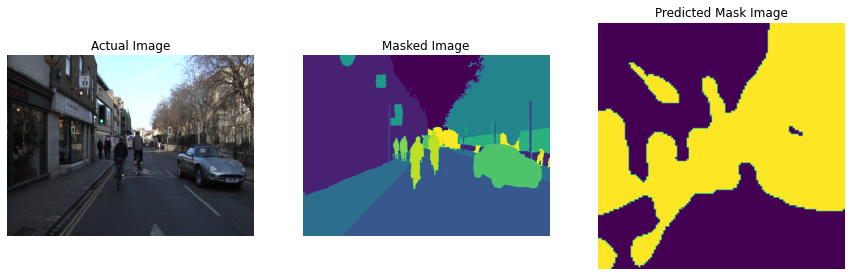

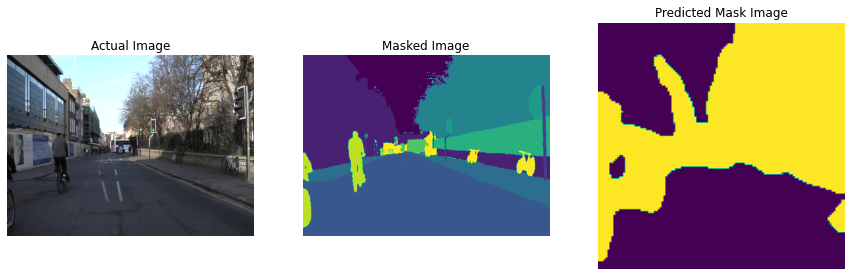

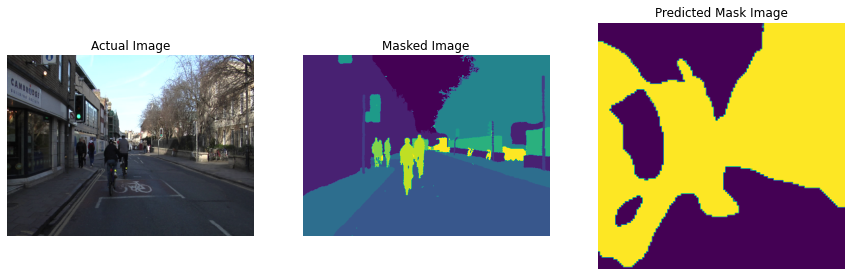

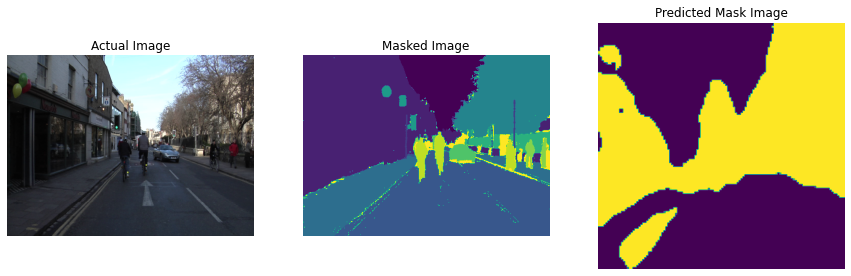

In [98]:
#Displaying Prediction results

for x in range(4):
  index = np.random.randint(imgs_test.shape[0])

  input_img = imgs_test[index]
  input_img_resize = tf.image.resize(input_img, (128,128))
  input_mask = masks_test[index]

  eval_mask = tf.squeeze(vgg_UNet(tf.expand_dims(input_img_resize, axis=0)))
  eval_mask1 = pred_mask(eval_mask)

  display_results([input_img, input_mask, eval_mask1])

#VGG19_UNet Model

In [102]:
# from tensorflow.keras.applications.vgg19 import VGG19
# vgg19 = VGG19(include_top=False, weights = 'imagenet')
# vgg19.summary()

In [103]:
def vgg19UNet(input_shape):
  input = Input(shape=input_shape)
  vgg19 = VGG19(include_top=False, weights = 'imagenet', input_tensor= input)
  e1 = vgg19.get_layer('block1_conv2').output # encoder layer 1
  e2 = vgg19.get_layer('block2_conv2').output # encoder layer 2
  e3 = vgg19.get_layer('block3_conv4').output # encoder layer 3
  e4 = vgg19.get_layer('block4_conv4').output # encoder layer 4

  b1 = vgg19.get_layer('block5_conv4').output # bridge layer

  d1 = decode_block(b1,e4,512) # decoder layer 1
  d2 = decode_block(d1,e3,256) # decoder layer 2
  d3 = decode_block(d2,e2,128) # decoder layer 3
  d4 = decode_block(d3,e1,64) # decoder layer 4

  conv2d = Conv2D(32,(3,3),padding='same', activation='relu', kernel_initializer="he_normal")(d4)

  op = Conv2D(1,1,padding='same', activation='sigmoid')(conv2d) # output layer

  modelvg = Model(input, op)

  return modelvg

In [104]:
img_size = (128,128,3)
vgg19_UNet = vgg19UNet(img_size)

vgg19_UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', dice_score])
vgg19_UNet.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

In [105]:
checkpoint_dir = data_dir + '/VGG19_UNet'

# aug_train_resize = tf.image.resize(aug_trainData, (128,128))
imgs_train_resize = tf.image.resize(imgs_train, (128,128))
masks_train_resize = tf.image.resize(masks_train, (128,128))

checkpoint_callback = ModelCheckpoint(filepath= checkpoint_dir, monitor='val_accuracy', mode='max', save_best_only=True)
vggUNet_19 = vgg19_UNet.fit(imgs_train_resize, masks_train_resize, batch_size= 32 ,epochs= 20,verbose=1,  validation_split=0.2, callbacks=[checkpoint_callback])

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3087 - dice_score: 1.3045

10/10 [==============================] - 52s 5s/step - loss: 0.0000e+00 - accuracy: 0.3087 - dice_score: 1.3045 - val_loss: 0.0000e+00 - val_accuracy: 0.1655 - val_dice_score: 0.5873
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2623 - dice_score: 1.2842

10/10 [==============================] - 15s 2s/step - loss: 0.0000e+00 - accuracy: 0.2623 - dice_score: 1.2842 - val_loss: 0.0000e+00 - val_accuracy: 0.1796 - val_dice_score: 0.7053
Epoch 3/20
10/10 [==============================] - 4s 437ms/step - loss: 0.0000e+00 - accuracy: 0.2354 - dice_score: 1.1379 - val_loss: 0.0000e+00 - val_accuracy: 0.1471 - val_dice_score: 0.0313
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2301 - dice_score: 1.1959

10/10 [==============================] - 15s 2s/step - loss: 0.0000e+00 - accuracy: 0.2301 - dice_score: 1.1959 - val_loss: 0.0000e+00 - val_accuracy: 0.1955 - val_dice_score: 1.2191
Epoch 5/20
10/10 [==============================] - 5s 463ms/step - loss: 0.0000e+00 - accuracy: 0.2335 - dice_score: 1.2670 - val_loss: 0.0000e+00 - val_accuracy: 0.1539 - val_dice_score: 0.5912
Epoch 6/20
10/10 [==============================] - 5s 453ms/step - loss: 0.0000e+00 - accuracy: 0.2723 - dice_score: 1.2685 - val_loss: 0.0000e+00 - val_accuracy: 0.1484 - val_dice_score: 0.1874
Epoch 7/20
10/10 [==============================] - 5s 492ms/step - loss: 0.0000e+00 - accuracy: 0.2875 - dice_score: 1.2954 - val_loss: 0.0000e+00 - val_accuracy: 0.1499 - val_dice_score: 0.4409
Epoch 8/20
10/10 [==============================] - 4s 444ms/step - loss: 0.0000e+00 - accuracy: 0.2602 - dice_score: 1.2824 - val_loss: 0.0000e+00 - val_accuracy: 0.1744 - val_dice_score: 1.1191
Epoch 9/20
10/10 [===============

10/10 [==============================] - 16s 2s/step - loss: 0.0000e+00 - accuracy: 0.2513 - dice_score: 1.3027 - val_loss: 0.0000e+00 - val_accuracy: 0.2469 - val_dice_score: 1.2253
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2599 - dice_score: 1.2979

10/10 [==============================] - 15s 2s/step - loss: 0.0000e+00 - accuracy: 0.2599 - dice_score: 1.2979 - val_loss: 0.0000e+00 - val_accuracy: 0.2542 - val_dice_score: 1.0061
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2703 - dice_score: 1.3156

10/10 [==============================] - 14s 2s/step - loss: 0.0000e+00 - accuracy: 0.2703 - dice_score: 1.3156 - val_loss: 0.0000e+00 - val_accuracy: 0.2793 - val_dice_score: 1.2793
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2938 - dice_score: 1.3325

10/10 [==============================] - 12s 1s/step - loss: 0.0000e+00 - accuracy: 0.2938 - dice_score: 1.3325 - val_loss: 0.0000e+00 - val_accuracy: 0.2966 - val_dice_score: 1.2886
Epoch 13/20
10/10 [==============================] - 4s 440ms/step - loss: 0.0000e+00 - accuracy: 0.3163 - dice_score: 1.3891 - val_loss: 0.0000e+00 - val_accuracy: 0.1910 - val_dice_score: 1.2065
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.3391 - dice_score: 1.4514

10/10 [==============================] - 13s 1s/step - loss: 0.0000e+00 - accuracy: 0.3391 - dice_score: 1.4514 - val_loss: 0.0000e+00 - val_accuracy: 0.3104 - val_dice_score: 1.4589
Epoch 15/20
10/10 [==============================] - 4s 441ms/step - loss: 0.0000e+00 - accuracy: 0.3480 - dice_score: 1.5061 - val_loss: 0.0000e+00 - val_accuracy: 0.2659 - val_dice_score: 1.4393
Epoch 16/20
10/10 [==============================] - 4s 443ms/step - loss: 0.0000e+00 - accuracy: 0.3441 - dice_score: 1.5214 - val_loss: 0.0000e+00 - val_accuracy: 0.2621 - val_dice_score: 1.4758
Epoch 17/20
10/10 [==============================] - 4s 446ms/step - loss: 0.0000e+00 - accuracy: 0.3180 - dice_score: 1.5238 - val_loss: 0.0000e+00 - val_accuracy: 0.2496 - val_dice_score: 1.4858
Epoch 18/20
10/10 [==============================] - 4s 448ms/step - loss: 0.0000e+00 - accuracy: 0.3041 - dice_score: 1.5273 - val_loss: 0.0000e+00 - val_accuracy: 0.2481 - val_dice_score: 1.4902
Epoch 19/20
10/10 [==========

##Performance Results VGG19_UNet

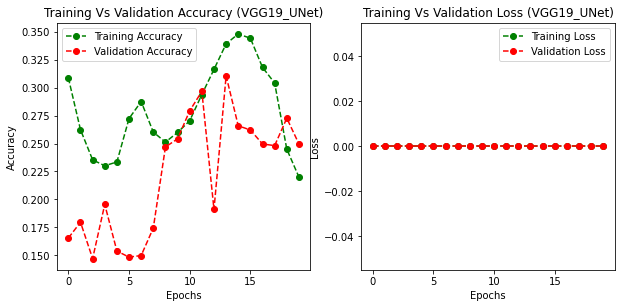

Text(0.5, 1.0, 'Training Vs Validation Dice Score (VGG19_UNet)')

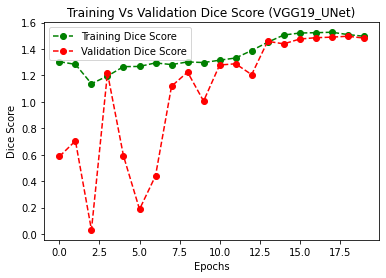

In [120]:
train_acc=vggUNet_19.history['accuracy']
train_loss=vggUNet_19.history['loss']
train_dice=vggUNet_19.history['dice_score']

val_acc=vggUNet_19.history['val_accuracy']
val_loss=vggUNet_19.history['val_loss']
val_dice=vggUNet_19.history['val_dice_score']

plt.figure(figsize=(10,10))
#Plotting Accuracy 
plt.subplot(2,2,1)
plt.plot(train_acc,'go--', label='Training Accuracy')
plt.plot(val_acc, 'ro--',label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training Vs Validation Accuracy (VGG19_UNet)')

#Plotting Loss
plt.subplot(2,2,2) 
plt.plot(train_loss,'go--', label='Training Loss')
plt.plot(val_loss, 'ro--',label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training Vs Validation Loss (VGG19_UNet)')
plt.show()

#Plotting Dice Score 
plt.subplot(1,1,1)
plt.plot(train_dice,'go--', label='Training Dice Score')
plt.plot(val_dice, 'ro--',label='Validation Dice Score')
plt.ylabel('Dice Score')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training Vs Validation Dice Score (VGG19_UNet)')

In [107]:
#Saving VGG16_UNet Model

saved_dir = data_dir + '/VGG19_UNet/Model'
vgg19_UNet.save(saved_dir)

In [108]:
#Load Saved Model
# from tensorflow import keras
# saved_dir = data_dir + '/VGG19_UNet/Model'
# loadVGG19_UNet_Model = keras.models.load_model(saved_dir, custom_objects=dice_score)

# loadVGG19_UNet_Model.summary()

##Displaying Prediction Results

In [109]:
def display_results(pred_results):
  plt.figure(figsize=(15,15))
  title_list = ['Actual Image', 'Masked Image', 'Predicted Mask Image']
  for x in range(len(pred_results)):
    plt.subplot(1, len(pred_results), x+1)
    plt.title(title_list[x])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_results[x]))
    plt.axis('off') 

  plt.show()

In [110]:
def pred_mask(predict):
  preedict = tf.argmax(predict, axis =-1)
  predict = predict[..., tf.newaxis]
  return predict

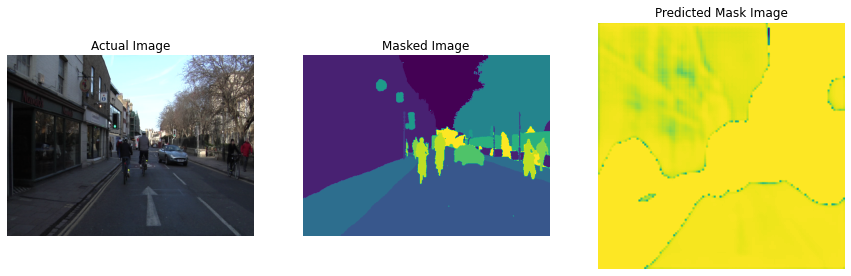

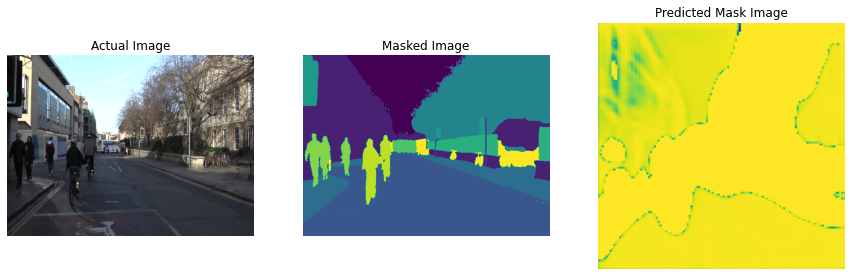

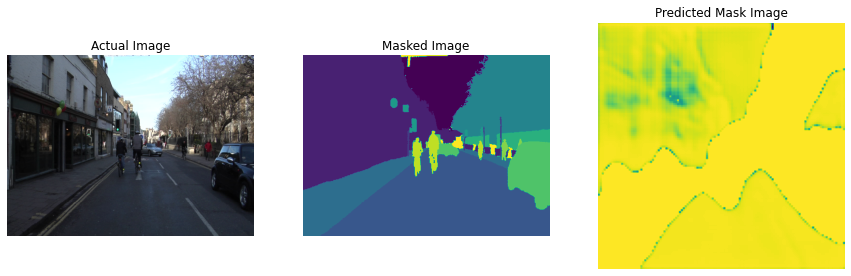

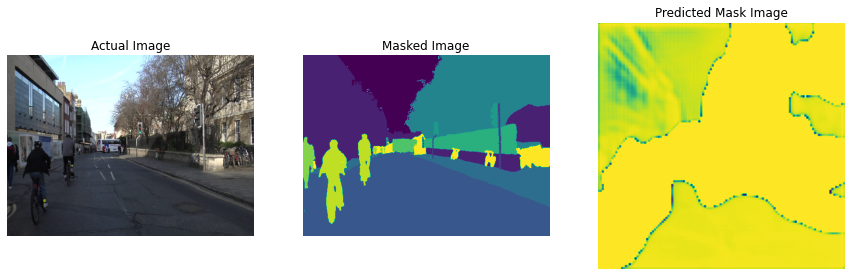

In [111]:
#Displaying Prediction results

for x in range(4):
  index = np.random.randint(imgs_test.shape[0])

  input_img = imgs_test[index]
  input_img_resize = tf.image.resize(input_img, (128,128))
  input_mask = masks_test[index]

  eval_mask = tf.squeeze(vgg19_UNet(tf.expand_dims(input_img_resize, axis=0)))
  eval_mask1 = pred_mask(eval_mask)

  display_results([input_img, input_mask, eval_mask1])